# SET the Image Resolution

In [1]:
from helper import IMAGE_RES

# SET the no of Images to Be Trained

In [2]:
LIMIT = 200

# Import Libraries

In [3]:
import os
import cv2
import time
import json
import keras
import tensorflow
import numpy as np
import seaborn as sns
from PIL import Image
import mediapipe as mp
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from helper import build_directory_lookup, get_subdirectory
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)

# Data Load 

In [4]:
# training

# define the subdirectory where you training data is located
training_sub = "data/asl_alphabet_train"
testing_sub = "data/asl_alphabet_test"

training_path = get_subdirectory(training_sub)
directory_lookup, directory_reverse_lookup = build_directory_lookup(training_path)

file_name = "directory_reverse_lookup.json"

# Save the dictionary to a JSON file
with open(file_name, "w") as json_file:
    json.dump(directory_reverse_lookup, json_file)


print(directory_lookup)
print("--------------------------")
print(directory_reverse_lookup)

Current Directory: c:\Users\navee\Projects\ASL-Fingerspelling-Recognition
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'del': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'nothing': 15, 'O': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'space': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28}
--------------------------
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'del', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'nothing', 16: 'O', 17: 'P', 18: 'Q', 19: 'R', 20: 'S', 21: 'space', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z'}


In [5]:
# training


# Images in x_train
x_train = []
# Labels in y_train
y_train = []
datacount = 0
for i in range(0, len(directory_lookup.keys())):
    class_directory = os.path.join(training_path, directory_reverse_lookup[i])
    limit_count = 0
    for j in os.listdir(class_directory):
        if limit_count <= LIMIT:
            limit_count += 1
        else:
            limit_count = 0
            break
        if not j.startswith("."):
            count = 0
            img = Image.open(os.path.join(class_directory, j)).convert("RGB")
            img = img.resize((IMAGE_RES, IMAGE_RES))
            arr = np.array(img)
            x_train.append(arr)
            count = count + 1
            y_values_t = np.full(
                (count, 1), directory_lookup[directory_reverse_lookup[i]]
            )
            y_train.append(y_values_t)
            datacount = datacount + count
x_train: np = np.array(x_train, dtype="float32")
y_train: np = np.array(y_train)
y_train: np = y_train.reshape(datacount)

# Check image

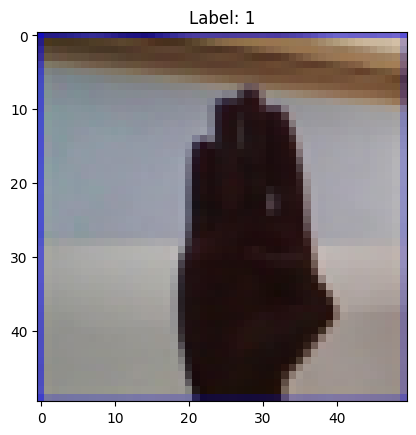

In [6]:
index_to_display = 201

# Display the image
plt.imshow(x_train[index_to_display].astype("uint8"))
plt.title(f"Label: {y_train[index_to_display]}")
plt.show()

# Data Split

In [7]:
# split the data into train , validation/ test 7:3 split respectively
x_train, x_valid_test, y_train, y_valid_test = train_test_split(
    x_train, y_train, test_size=0.3, random_state=42
)

# Split the combined validation/testing set into validation and testing sets 8:2 split respectively
x_validation, x_test, y_validation, y_test = train_test_split(
    x_valid_test, y_valid_test, test_size=0.2, random_state=42
)

# Print the shapes to verify the split
print("Training data shapes:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("Validation data shapes:")
print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)

print("Testing data shapes:")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Training data shapes:
x_train shape: (4080, 50, 50, 3)
y_train shape: (4080,)
Validation data shapes:
x_validation shape: (1399, 50, 50, 3)
y_validation shape: (1399,)
Testing data shapes:
x_test shape: (350, 50, 50, 3)
y_test shape: (350,)


In [8]:
# training
y_train: np = to_categorical(y_train)
x_train: np = x_train / 255
x_train: np = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# validation
y_validation: np = to_categorical(y_validation)
x_validation: np = x_validation / 255
x_validation: np = x_validation.reshape(
    (x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 3)
)

# test
y_test: np = to_categorical(y_test)
x_test: np = x_test / 255
x_test: np = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))

In [9]:
x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((4080, 50, 50, 3),
 (4080, 29),
 (1399, 50, 50, 3),
 (1399, 29),
 (350, 50, 50, 3),
 (350, 29))

In [11]:
num_classes = len(directory_reverse_lookup.keys())


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1


model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_RES, IMAGE_RES, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu", kernel_regularizer="l2"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Implement early stopping and learning rate scheduling
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 22, 22, 64)        256       
 chNormalization)                                                
                                                        

In [12]:
# Train the model
epochs = 50 # You can adjust the number of epochs
batch_size = 32  # You can adjust the batch size

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50
128/128 [==============================] - 7s 48ms/step - loss: 4.1591 - accuracy: 0.4676 - val_loss: 7.4077 - val_accuracy: 0.0315 - lr: 0.0010
Epoch 2/50
128/128 [==============================] - 6s 48ms/step - loss: 2.2452 - accuracy: 0.8240 - val_loss: 8.1989 - val_accuracy: 0.0279 - lr: 0.0010
Epoch 3/50
128/128 [==============================] - 6s 48ms/step - loss: 1.3522 - accuracy: 0.9368 - val_loss: 5.0373 - val_accuracy: 0.0436 - lr: 0.0010
Epoch 4/50
128/128 [==============================] - 6s 49ms/step - loss: 0.8594 - accuracy: 0.9684 - val_loss: 2.8306 - val_accuracy: 0.4360 - lr: 0.0010
Epoch 5/50
128/128 [==============================] - 6s 47ms/step - loss: 0.5687 - accuracy: 0.9821 - val_loss: 0.7277 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 6/50
128/128 [==============================] - 6s 48ms/step - loss: 0.4523 - accuracy: 0.9775 - val_loss: 0.9569 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 7/50
128/128 [==============================] - 6s 46ms/st

In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

11/11 [==============================] - 0s 17ms/step - loss: 0.2883 - accuracy: 0.9943
Test accuracy: 99.43%


In [14]:
model.save_weights("model_weights_2.h5")

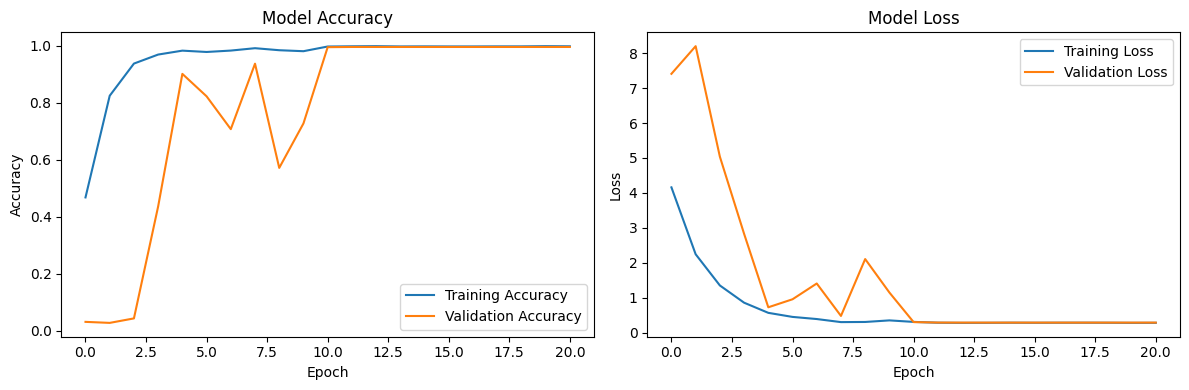

In [15]:
# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
axes[0].plot(history.history["accuracy"], label="Training Accuracy")
axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="lower right")

# Plot training & validation loss
axes[1].plot(history.history["loss"], label="Training Loss")
axes[1].plot(history.history["val_loss"], label="Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend(loc="upper right")

# Ensure proper layout and show the plots
plt.tight_layout()
plt.show()

11/11 [==============================] - 0s 12ms/step


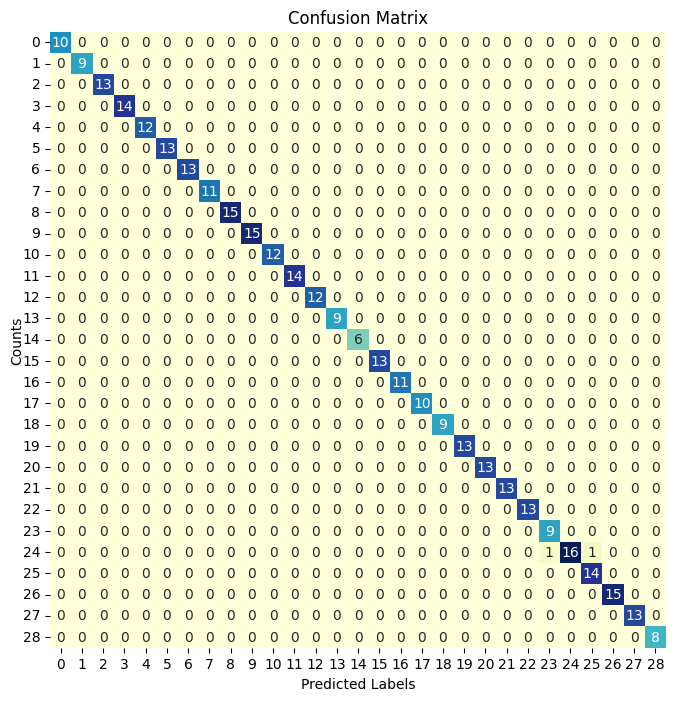

In [16]:
test_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pred, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Create a heatmap with Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", cbar=False, square=True)

# Set labels and titles
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Customize the color bar (optional)
cax = plt.gcf().axes[-1]
cax.set_yticklabels(cax.get_yticklabels(), rotation=0)
cax.set_ylabel("Counts", rotation=90, va="center")

plt.show()